# Packages

In [2]:
import pandas as pd
import duckdb as db
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

In [2]:
import os
print(os.getcwd())

/Users/gaberiedel/baseball_projects/SMT_2025/backend/analysis_code


# Steal Plays

##### SQL Querying of Steals

In [ ]:
with db.connect("../database/smt_2025.db") as con:
    # Find all unique baserunners who have been on first base
    players_on_first = con.sql("""SELECT DISTINCT first_baserunner AS player_name FROM game_info""").df()

    # Find the number of times each distinct baserunner as been on first base
    plays_on_first = con.sql("""SELECT COUNT(*) count_on_first, 
                             first_baserunner AS player_name 
                             FROM game_info 
                             WHERE first_baserunner != 'NA' AND second_baserunner = 'NA' 
                                AND third_baserunner = 'NA'
                             GROUP BY first_baserunner
                             ORDER BY COUNT(*) DESC""").df()
    
    steal_count = con.sql("""WITH pitches AS (SELECT * FROM 
                            (SELECT *,
                              LEAD(event_code) OVER (PARTITION BY game_str, play_per_game ORDER BY timestamp, event_code) AS next_event,
                              LEAD(player_position) OVER (PARTITION BY game_str, play_per_game ORDER BY timestamp, event_code) AS next_player
                              FROM game_events) subquery
                              WHERE event_code = 3 
                                AND player_position = 2  
                                AND (next_event = 2 OR next_event = 16) 
                                AND (next_player = 4 OR next_player = 6 OR next_player = 255)
                              ORDER BY game_str, play_per_game),
                           
                           runner_info AS (SELECT * 
                                            FROM game_info
                                            WHERE first_baserunner != 'NA' 
                                            AND second_baserunner = 'NA')
                          
                          SELECT COUNT(*) stolen_bases, 
                          player_name 
                          FROM
                            (SELECT pi.game_str, play_id, pi.play_per_game, player_position, event_code, pi.home_team, first_baserunner as player_name, second_baserunner 
                            FROM pitches pi
                            INNER JOIN runner_info ri
                            ON pi.game_str = ri.game_str AND pi.play_per_game = ri.play_per_game) subquery
                          GROUP BY player_name
                          ORDER BY COUNT(*) DESC;""").df()

    # Find steal plays, specifically a runner on first stealing second
    steal_plays = con.sql("""WITH pitches AS (SELECT * FROM 
                            (SELECT *, 
                          LEAD(event_code) OVER (PARTITION BY game_str, play_per_game ORDER BY timestamp, event_code) AS next_event,
                          LEAD(player_position) OVER (PARTITION BY game_str, play_per_game ORDER BY timestamp, event_code) AS next_player
                          FROM game_events) subquery
                          WHERE event_code = 3 
                          AND player_position = 2 
                          AND (next_event = 2 OR next_event = 16) 
                          AND (next_player = 4 OR next_player = 6 OR next_player = 255)
                          ORDER BY game_str, play_per_game),
                          
                          runner_info AS 
                          (SELECT * 
                          FROM game_info 
                          WHERE first_baserunner != 'NA'
                           AND second_baserunner = 'NA')
                          
                          SELECT pi.game_str, play_id, pi.play_per_game, player_position, event_code, pi.home_team, first_baserunner as player_name, second_baserunner 
                          FROM pitches pi
                          INNER JOIN runner_info ri
                          ON pi.game_str = ri.game_str 
                            AND pi.play_per_game = ri.play_per_game;""").df()
    
    # Find successful steal plays ****
    successful_steals = con.sql("""WITH pitches AS 
                                (SELECT * 
                                FROM game_events
                                WHERE event_code = 3 AND player_position = 2
                                ORDER BY game_str, play_per_game),
                          
                          runner_info AS 
                                (SELECT * FROM 
                                (SELECT *, 
                                    LEAD(first_baserunner) OVER (PARTITION BY game_str, top_bottom_inning ORDER BY play_per_game) AS next_first_base,
                                    LEAD(second_baserunner) OVER (PARTITION BY game_str, top_bottom_inning ORDER BY play_per_game) AS next_second_base,
                                    LEAD(third_baserunner) OVER (PARTITION BY game_str, top_bottom_inning ORDER BY play_per_game) AS next_third_base,
                                    LEAD(play_per_game) OVER (PARTITION BY game_str, top_bottom_inning ORDER BY play_per_game) AS next_play_id
                                    FROM game_info) subquery
                                    WHERE first_baserunner != 'NA' 
                                    AND next_second_base != 'NA' 
                                    AND second_baserunner = 'NA' 
                                    AND third_baserunner = 'NA'
                                    AND next_first_base = 'NA' 
                                    AND next_third_base = 'NA'
                                    ORDER BY game_str, play_per_game)
                          
                          SELECT pi.game_str, play_id, pi.play_per_game, player_position, event_code, pi.home_team, first_baserunner, second_baserunner, next_second_base, next_play_id
                          FROM pitches pi
                          INNER JOIN runner_info ri
                          ON pi.game_str = ri.game_str AND pi.play_per_game = ri.play_per_gamel""").df()
  

In [184]:
steal_count

,stolen_bases,player_name
0,8,RZQ-0347
1,6,RZQ-0310
2,6,RZQ-0333
3,5,YJD-0345
4,3,DYE-0089
...,...,...
124,1,HKR-1786
125,1,RZQ-0275
126,1,YJD-0429
127,1,NYA-1183


##### Save steals to csv

In [71]:
steal_plays["player_name"].value_counts()

player_name
RZQ-0347    8
RZQ-0333    6
RZQ-0310    6
YJD-0345    5
RZQ-0143    3
           ..
IXC-1848    1
GEA-1874    1
JJS-1834    1
CGA-1824    1
YJD-0312    1
Name: count, Length: 129, dtype: int64

In [7]:
# Save plays to csv to use for animation
steal_plays.to_csv("steal_plays.csv")

##### Steal Threat Statistic

In [190]:
df_runners = pd.merge(players_on_first, plays_on_first, on = "player_name", how = "left")
df_runners

,player_name,count_on_first
0,QEA-0263,110.0
1,ACN-1416,8.0
2,QEA-0369,70.0
3,APZ-1200,10.0
4,QEA-0364,63.0
...,...,...
893,WZR-1285,10.0
894,WZR-2183,16.0
895,WZR-1090,7.0
896,WZR-2401,3.0


In [191]:
df_runners = pd.merge(players_on_first, plays_on_first, on = "player_name", how = "left")
df_thieves = pd.merge(df_runners, steal_count, on="player_name", how="left").fillna(0).sort_values(by="stolen_bases", ascending=False)
df_thieves["steal_score"] = (df_thieves["stolen_bases"]/df_thieves["count_on_first"] * np.log(df_thieves["stolen_bases"])).fillna(0)
df_thieves.sort_values(by="steal_score", ascending=False)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log


,player_name,count_on_first,stolen_bases,steal_score
831,TSZ-1892,25.0,3.0,0.131833
510,VHS-2566,12.0,2.0,0.115525
548,XAX-1799,15.0,2.0,0.092420
190,NSO-1360,16.0,2.0,0.086643
23,RZQ-0310,143.0,6.0,0.075179
...,...,...,...,...
794,WJU-2497,4.0,0.0,0.000000
795,WJU-1346,18.0,0.0,0.000000
796,XAX-1882,3.0,0.0,0.000000
797,XAX-1460,24.0,0.0,0.000000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 30'. Pick better value with 'binwidth'.


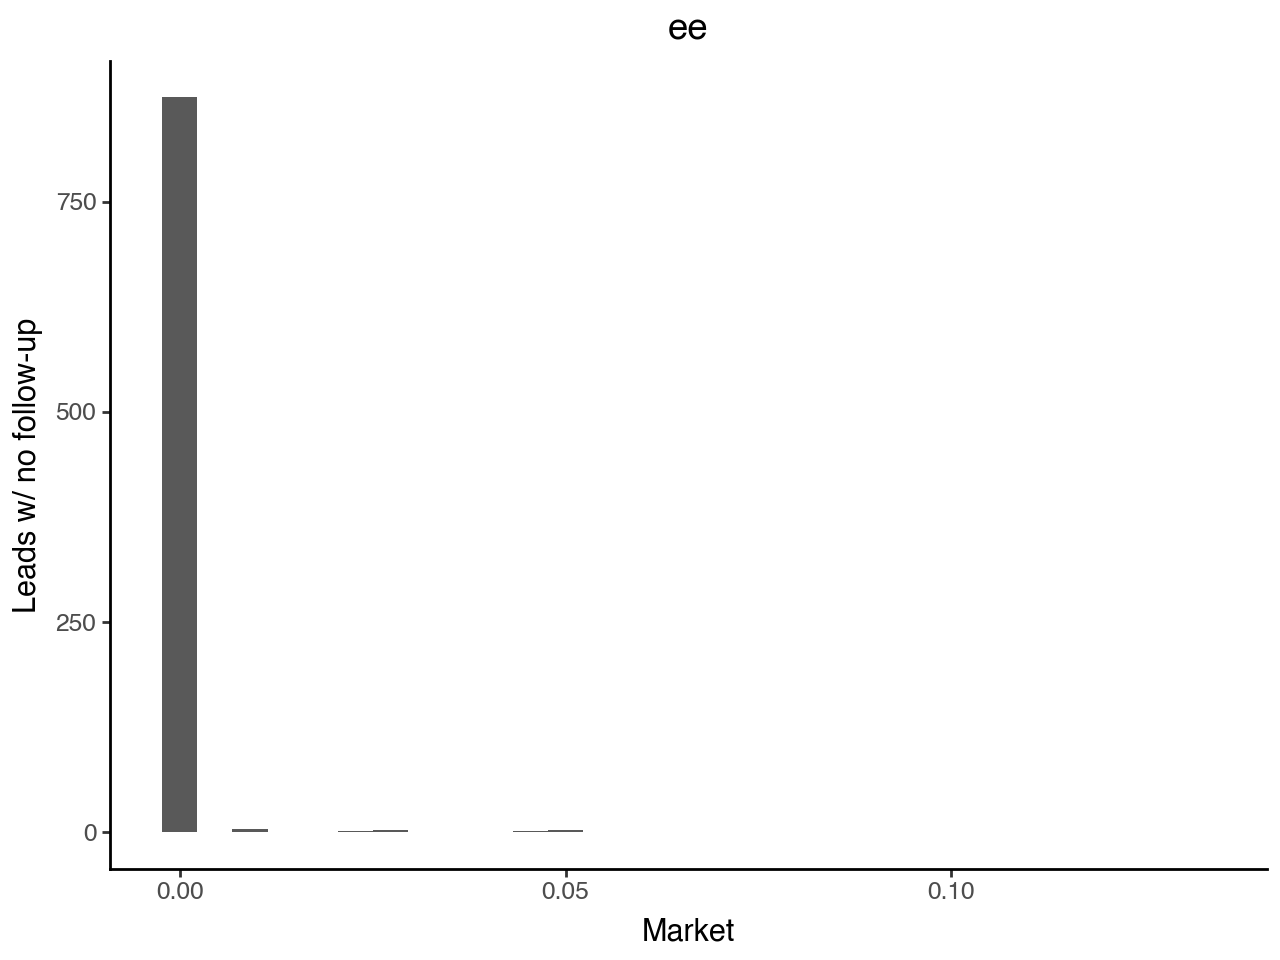

In [39]:
ggplot(df_thieves, aes(x='steal_score')) \
+ geom_histogram() \
+ labs(title = "ee",
       x="Market",
       y="Leads w/ no follow-up") \
+ theme_classic()

# Pickoff plays

In [192]:
with db.connect("../database/smt_2025.db") as con:
    df_pickoff_plays = con.sql("""
                               WITH first_base_player_pos AS (SELECT game_str, play_id, timestamp, player_position AS runner, field_x, field_y
                                FROM(
                                    SELECT *, DENSE_RANK() OVER (PARTITION BY game_str, play_id ORDER BY timestamp) as time_order
                                    FROM player_pos 
                                    WHERE player_position = 11
                                    ORDER BY game_str, play_id, timestamp) sub1
                                    WHERE time_order = 1)
                               SELECT ge.game_str, ge.play_id, player_position, event_code, ge.home_team, top_bottom_inning, pitcher, batter, first_baserunner as player_name, field_x, field_y 
                               FROM game_events ge
                               LEFT JOIN game_info gi 
                               ON ge.game_str = gi.game_str AND ge.play_per_game = gi.play_per_game
                               INNER JOIN first_base_player_pos fb
                               ON ge.game_str = fb.game_str AND ge.play_id = fb.play_id
                               WHERE player_position = 1 AND event_code = 6 
                                AND second_baserunner = 'NA' AND third_baserunner = 'NA' """).df()

df_pickoff_plays

,game_str,play_id,player_position,event_code,home_team,top_bottom_inning,pitcher,batter,player_name,field_x,field_y
0,y2_d065_ESW_YJD,99,1,6,YJD,top,YJD-0342,ESW-2445,ESW-1541,55.7679,73.0713
1,y2_d065_ESW_YJD,133,1,6,YJD,top,YJD-0342,ESW-2290,ESW-1908,57.3429,70.2201
2,y2_d065_HKR_RZQ,75,1,6,RZQ,bottom,HKR-2499,RZQ-0355,RZQ-0347,55.0299,73.1349
3,y2_d065_HKR_RZQ,77,1,6,RZQ,bottom,HKR-2499,RZQ-0355,RZQ-0347,55.6416,73.1847
4,y2_d065_HKR_RZQ,176,1,6,RZQ,bottom,HKR-2345,RZQ-0347,RZQ-0143,63.0666,63.5904
...,...,...,...,...,...,...,...,...,...,...,...
1200,y2_d024_ALA_YJD,138,1,6,YJD,top,YJD-0251,ALA-2442,ALA-1500,54.8082,75.4590
1201,y2_d024_ALA_YJD,196,1,6,YJD,bottom,ALA-2364,YJD-0327,YJD-0345,56.2056,74.1378
1202,y2_d024_ALA_YJD,241,1,6,YJD,bottom,ALA-2270,YJD-0345,YJD-0278,59.4483,69.3453
1203,y2_d025_ALA_YJD,16,1,6,YJD,bottom,ALA-1795,YJD-0174,YJD-0327,54.7938,72.4872


In [194]:
with db.connect("../database/smt_2025.db") as con:
    df_pitches = con.sql("""
                               WITH first_base_player_pos AS (SELECT game_str, play_id, timestamp, player_position AS runner, field_x, field_y
                                FROM(
                                    SELECT *, DENSE_RANK() OVER (PARTITION BY game_str, play_id ORDER BY timestamp) as time_order
                                    FROM player_pos 
                                    WHERE player_position = 11
                                    ORDER BY game_str, play_id, timestamp) sub1
                                    WHERE time_order = 1)
                               SELECT ge.game_str, ge.play_id, player_position, event_code, ge.home_team, top_bottom_inning, pitcher, batter, first_baserunner as player_name, field_x, field_y 
                               FROM game_events ge
                               LEFT JOIN game_info gi 
                               ON ge.game_str = gi.game_str AND ge.play_per_game = gi.play_per_game
                               INNER JOIN first_base_player_pos fb
                               ON ge.game_str = fb.game_str AND ge.play_id = fb.play_id
                               WHERE player_position = 1 AND event_code = 1 
                                AND second_baserunner = 'NA' AND third_baserunner = 'NA' 
                             """).df()
df_pitches

,game_str,play_id,player_position,event_code,home_team,top_bottom_inning,pitcher,batter,player_name,field_x,field_y
0,y1_d001_CGA_QEA,3,1,1,QEA,top,QEA-0110,CGA-2010,CGA-1458,54.2724,72.6843
1,y1_d001_CGA_QEA,4,1,1,QEA,top,QEA-0110,CGA-2010,CGA-1458,53.3751,74.7021
2,y1_d001_CGA_QEA,51,1,1,QEA,top,QEA-0404,CGA-1198,NA,55.1019,71.9826
3,y1_d001_CGA_QEA,53,1,1,QEA,top,QEA-0404,CGA-1198,NA,54.4506,72.7566
4,y1_d001_CGA_QEA,62,1,1,QEA,top,QEA-0404,CGA-1458,CGA-2223,58.1007,72.7665
...,...,...,...,...,...,...,...,...,...,...,...
14042,y2_d033_KNB_YJD,189,1,1,YJD,bottom,KNB-2155,YJD-0174,YJD-0327,55.0377,74.7573
14043,y2_d032_KNB_YJD,147,1,1,YJD,top,YJD-0335,KNB-1796,KNB-1155,59.1765,71.3448
14044,y2_d032_KNB_YJD,280,1,1,YJD,top,YJD-0293,KNB-1404,KNB-2309,54.2520,75.3063
14045,y2_d031_IKJ_RZQ,188,1,1,RZQ,top,RZQ-0375,IKJ-2180,IKJ-2029,55.8579,72.5907


In [154]:
df_pickoff_plays["lead_distance"] = np.sqrt(pow(df_pickoff_plays["field_x"]-63.63, 2) + pow(df_pickoff_plays["field_y"]-63.63, 2)) - 1.25
df_pickoff_plays["lead_distance"].mean()

np.float64(10.028087972768745)

In [155]:
df_pickoff_plays = pd.merge(df_pickoff_plays, df_thieves, on="player_name", how = "left")

df_pickoff_plays.sort_values(by='steal_score')

,game_str,play_id,player_position,event_code,home_team,top_bottom_inning,pitcher,batter,player_name,field_x,field_y,lead_distance,count_on_first,stolen_bases,steal_score
0,y1_d058_OXG_QEA,150,1,6,QEA,bottom,OXG-0109,QEA-0235,QEA-0364,55.6104,74.0472,11.896560,63.0,0.0,0.000000
709,y2_d025_ALA_YJD,141,1,6,YJD,bottom,ALA-1795,YJD-0345,YJD-0327,56.6034,70.7070,8.722815,158.0,1.0,0.000000
710,y2_d025_ALA_YJD,177,1,6,YJD,top,YJD-0293,ALA-1726,ALA-1387,55.9473,70.9563,9.365957,11.0,0.0,0.000000
711,y2_d025_ALA_YJD,179,1,6,YJD,top,YJD-0293,ALA-1726,ALA-1387,55.9935,70.5978,9.087619,11.0,0.0,0.000000
712,y2_d025_ALA_YJD,199,1,6,YJD,bottom,ALA-1867,YJD-0327,YJD-0080,57.5133,70.0779,7.637600,84.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,y2_d010_TSZ_RZQ,89,1,6,RZQ,top,RZQ-0324,TSZ-1361,TSZ-1892,55.4571,72.7794,11.018163,25.0,3.0,0.131833
458,y2_d009_TSZ_RZQ,64,1,6,RZQ,top,RZQ-0267,TSZ-2189,TSZ-1892,55.6131,72.8511,10.968812,25.0,3.0,0.131833
457,y2_d009_TSZ_RZQ,63,1,6,RZQ,top,RZQ-0267,TSZ-2189,TSZ-1892,55.0854,72.7971,11.281796,25.0,3.0,0.131833
476,y2_d010_TSZ_RZQ,88,1,6,RZQ,top,RZQ-0324,TSZ-1361,TSZ-1892,54.9912,72.5991,11.202856,25.0,3.0,0.131833


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 135'. Pick better value with 'binwidth'.


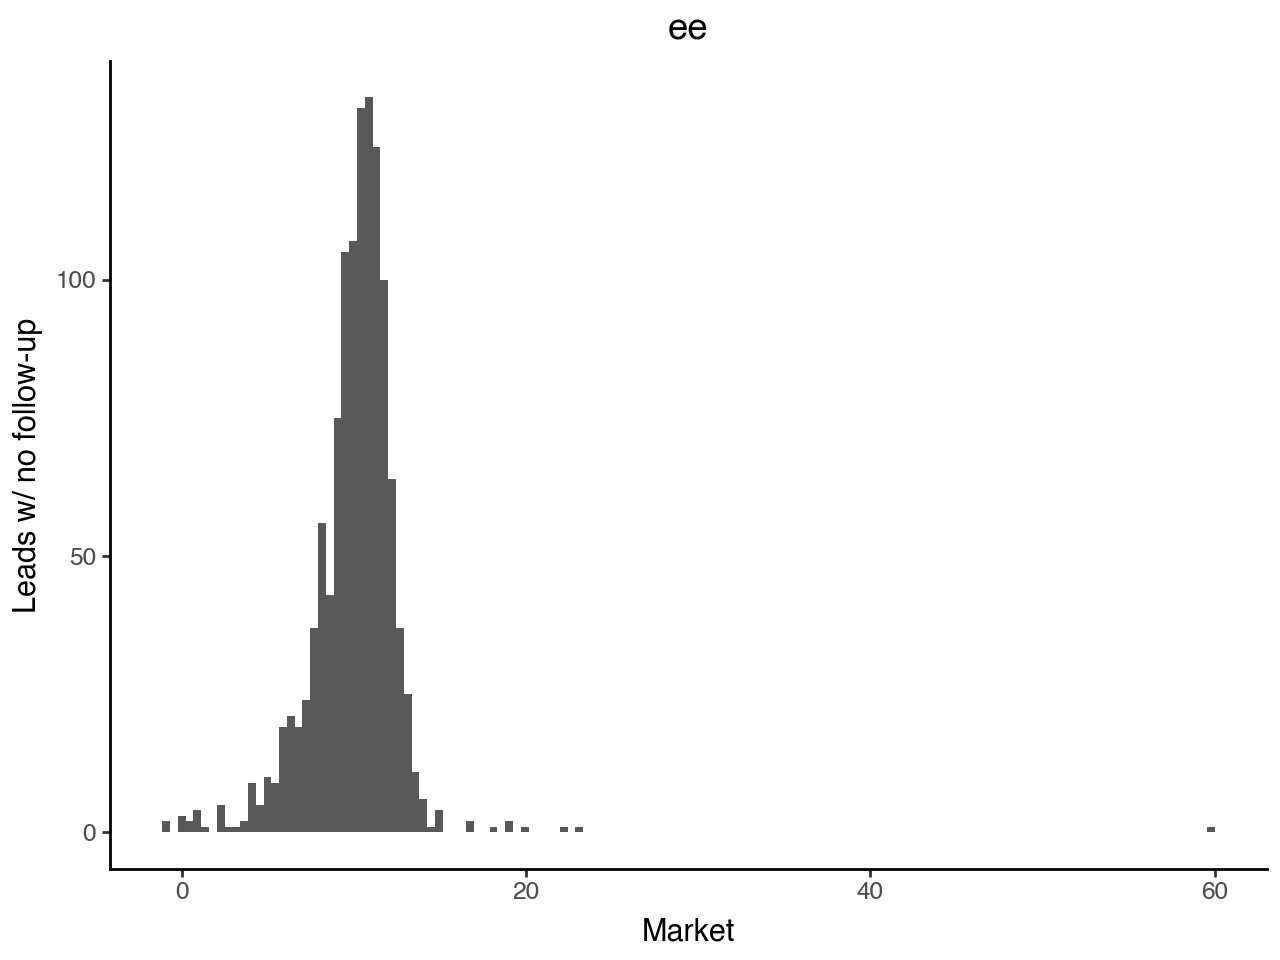

In [77]:
ggplot(df_pickoff_plays, aes(x='lead_distance')) \
+ geom_histogram() \
+ labs(title = "ee",
       x="Market",
       y="Leads w/ no follow-up") \
+ theme_classic()

In [156]:
df_pickoff_plays["is_home"] = np.where(df_pickoff_plays['top_bottom_inning'] == "top", 1, 0)
df_pickoff_plays

,game_str,play_id,player_position,event_code,home_team,top_bottom_inning,pitcher,batter,player_name,field_x,field_y,lead_distance,count_on_first,stolen_bases,steal_score,is_home
0,y1_d058_OXG_QEA,150,1,6,QEA,bottom,OXG-0109,QEA-0235,QEA-0364,55.6104,74.0472,11.896560,63.0,0.0,0.0,0
1,y1_d058_OXG_QEA,212,1,6,QEA,bottom,OXG-0109,QEA-0027,NA,58.6446,68.4462,5.681810,0.0,0.0,0.0,0
2,y1_d058_OXG_QEA,271,1,6,QEA,bottom,OXG-0109,QEA-0027,NA,59.0655,66.1983,3.987445,0.0,0.0,0.0,0
3,y1_d059_JNJ_QEA,68,1,6,QEA,top,QEA-0013,JNJ-1459,NA,59.1960,68.9358,5.664613,0.0,0.0,0.0,1
4,y1_d059_JNJ_QEA,174,1,6,QEA,bottom,JNJ-1560,QEA-0364,NA,54.9798,74.6028,12.722412,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,y2_d092_NYA_YJD,104,1,6,YJD,top,YJD-0138,NYA-2311,NYA-1911,59.4303,72.2535,8.341779,15.0,0.0,0.0,1
1201,y2_d099_YJD_RZQ,8,1,6,RZQ,top,RZQ-0285,YJD-0132,YJD-0019,57.4158,69.3369,7.187120,58.0,1.0,0.0,1
1202,y2_d099_YJD_RZQ,108,1,6,RZQ,bottom,YJD-0386,RZQ-0414,RZQ-0328,60.1239,68.5986,4.831096,26.0,1.0,0.0,0
1203,y2_d092_NYA_YJD,24,1,6,YJD,top,YJD-0138,NYA-1911,NYA-1183,55.3851,69.9564,9.142387,14.0,1.0,0.0,1


In [157]:
with db.connect("../database/smt_2025.db") as con:
    df_pickoff_counts = con.sql("""SELECT COUNT(*) AS pickoffs, pitcher
                          FROM
                          (SELECT * FROM game_events ge
                          LEFT JOIN game_info gi
                          ON ge.game_str = gi.game_str AND ge.play_per_game = gi.play_per_game
                          WHERE event_code = 6) subquery
                          GROUP BY pitcher
                          ORDER BY COUNT(*) DESC;""").df()
    df_pitches_thrown = con.sql("""SELECT COUNT(*) AS pitches, pitcher
                                  FROM game_info
                                  GROUP BY pitcher
                                  ORDER BY COUNT(*) DESC;""").df()
    
df_pitchers = pd.merge(df_pitches_thrown, df_pickoff_counts, on="pitcher", how = "left")
df_pitchers["pickoffs"] = df_pitchers["pickoffs"].fillna(0)
df_pitchers = df_pitchers[df_pitchers["pitches"] > 20]
df_pitchers


,pitches,pitcher,pickoffs
0,1918,YJD-0420,42.0
1,1257,RZQ-0324,21.0
2,1160,YJD-0293,24.0
3,920,RZQ-0082,16.0
4,856,YJD-0335,17.0
...,...,...,...
656,21,VMN-2193,0.0
657,21,OXG-0054,0.0
658,21,HCI-1672,0.0
659,21,UWE-1275,0.0


In [19]:
with db.connect("../database/smt_2025.db") as con:    
    df_first_runner = con.sql("""SELECT * 
                              FROM player_pos pp
                              LEFT JOIN game_events ge
                              ON pp.game_str = ge.game_str AND pp.play_id = ge.play_id
                              WHERE pp.player_position = 11
                              LIMIT 100;""").df()
df_first_runner

,game_str,play_id,timestamp,player_position,field_x,field_y,home_team,away_team,year,day,...,play_id_1,at_bat,play_per_game,timestamp_1,player_position_1,event_code,home_team_1,away_team_1,year_1,day_1
0,y1_d070_ACN_QEA,227,7478837,11,41.8926,85.8288,QEA,ACN,year_1,day_070,...,227,54,227,7482937,0,5,QEA,ACN,year_1,day_070
1,y1_d070_ACN_QEA,227,7478887,11,41.3400,86.3949,QEA,ACN,year_1,day_070,...,227,54,227,7482937,0,5,QEA,ACN,year_1,day_070
2,y1_d070_ACN_QEA,227,7478937,11,40.7874,86.9610,QEA,ACN,year_1,day_070,...,227,54,227,7482937,0,5,QEA,ACN,year_1,day_070
3,y1_d070_ACN_QEA,227,7478987,11,40.2348,87.5271,QEA,ACN,year_1,day_070,...,227,54,227,7482937,0,5,QEA,ACN,year_1,day_070
4,y1_d070_ACN_QEA,227,7479037,11,39.6819,88.0932,QEA,ACN,year_1,day_070,...,227,54,227,7482937,0,5,QEA,ACN,year_1,day_070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,y1_d070_ACN_QEA,228,7521987,11,55.9545,68.8143,QEA,ACN,year_1,day_070,...,228,55,228,7524837,0,5,QEA,ACN,year_1,day_070
96,y1_d070_ACN_QEA,228,7522037,11,55.9515,68.8311,QEA,ACN,year_1,day_070,...,228,55,228,7524837,0,5,QEA,ACN,year_1,day_070
97,y1_d070_ACN_QEA,228,7522087,11,55.9488,68.8479,QEA,ACN,year_1,day_070,...,228,55,228,7524837,0,5,QEA,ACN,year_1,day_070
98,y1_d070_ACN_QEA,228,7522137,11,55.9458,68.8647,QEA,ACN,year_1,day_070,...,228,55,228,7524837,0,5,QEA,ACN,year_1,day_070


# Pitcher Handedness

In [158]:
with db.connect("../database/smt_2025.db") as con:
    df_pitchers = con.sql("""SELECT DISTINCT pitcher FROM game_info""").df()
    df_pitcher_hand = con.sql("""WITH rp AS 
                         (SELECT * FROM
                         (SELECT ball_position_x, play_id, game_str,
                         DENSE_RANK() OVER (PARTITION BY game_str, play_id ORDER BY timestamp) AS rank
                         FROM ball_pos bp) AS subquery
                         WHERE rank = 1), 

                         pitcher_rp AS (
                         SELECT rp.game_str, rp.ball_position_x, pitcher 
                         FROM rp
                         LEFT JOIN game_info gi
                         ON rp.game_str = gi.game_str AND rp.play_id = gi.play_per_game)
                         
                         SELECT AVG(ball_position_x) avg_rel_point, pitcher FROM pitcher_rp
                         GROUP BY pitcher;""").df()

df_pitcher_hand["hand"] = np.where(df_pitcher_hand["avg_rel_point"] > 0, "L", "R")
df_pitcher_hand


,avg_rel_point,pitcher,hand
0,-0.831424,RZQ-0379,R
1,0.680283,TKJ-1551,L
2,-1.408302,WJU-1336,R
3,1.003340,YJD-0370,L
4,-2.134203,QEA-0217,R
...,...,...,...
880,-1.904121,MGJ-2574,R
881,1.869925,MCJ-2295,L
882,-1.829775,NSO-1745,R
883,4.485030,YJD-0243,L


In [159]:
df_pickoff_plays = pd.merge(df_pickoff_plays, df_pitcher_hand, on="pitcher", how="left")
df_pickoff_plays


,game_str,play_id,player_position,event_code,home_team,top_bottom_inning,pitcher,batter,player_name,field_x,field_y,lead_distance,count_on_first,stolen_bases,steal_score,is_home,avg_rel_point,hand
0,y1_d058_OXG_QEA,150,1,6,QEA,bottom,OXG-0109,QEA-0235,QEA-0364,55.6104,74.0472,11.896560,63.0,0.0,0.0,0,-0.597738,R
1,y1_d058_OXG_QEA,212,1,6,QEA,bottom,OXG-0109,QEA-0027,NA,58.6446,68.4462,5.681810,0.0,0.0,0.0,0,-0.597738,R
2,y1_d058_OXG_QEA,271,1,6,QEA,bottom,OXG-0109,QEA-0027,NA,59.0655,66.1983,3.987445,0.0,0.0,0.0,0,-0.597738,R
3,y1_d059_JNJ_QEA,68,1,6,QEA,top,QEA-0013,JNJ-1459,NA,59.1960,68.9358,5.664613,0.0,0.0,0.0,1,-1.151005,R
4,y1_d059_JNJ_QEA,174,1,6,QEA,bottom,JNJ-1560,QEA-0364,NA,54.9798,74.6028,12.722412,0.0,0.0,0.0,0,-1.163131,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,y2_d092_NYA_YJD,104,1,6,YJD,top,YJD-0138,NYA-2311,NYA-1911,59.4303,72.2535,8.341779,15.0,0.0,0.0,1,2.090306,L
1201,y2_d099_YJD_RZQ,8,1,6,RZQ,top,RZQ-0285,YJD-0132,YJD-0019,57.4158,69.3369,7.187120,58.0,1.0,0.0,1,2.331011,L
1202,y2_d099_YJD_RZQ,108,1,6,RZQ,bottom,YJD-0386,RZQ-0414,RZQ-0328,60.1239,68.5986,4.831096,26.0,1.0,0.0,0,1.375744,L
1203,y2_d092_NYA_YJD,24,1,6,YJD,top,YJD-0138,NYA-1911,NYA-1183,55.3851,69.9564,9.142387,14.0,1.0,0.0,1,2.090306,L


In [160]:
df_pitchers = pd.merge(df_pitchers, df_pitcher_hand, on='pitcher', how='left')
df_pitchers


,pitcher,avg_rel_point,hand
0,APZ-2333,-1.134705,R
1,APZ-1788,1.015467,L
2,QEA-0150,-1.731004,R
3,CGA-1078,-2.049687,R
4,CGA-2164,-1.755800,R
...,...,...,...
879,VHS-1066,-2.764239,R
880,VMN-2511,2.537699,L
881,VZE-2259,1.575376,L
882,WMI-2430,2.907968,L


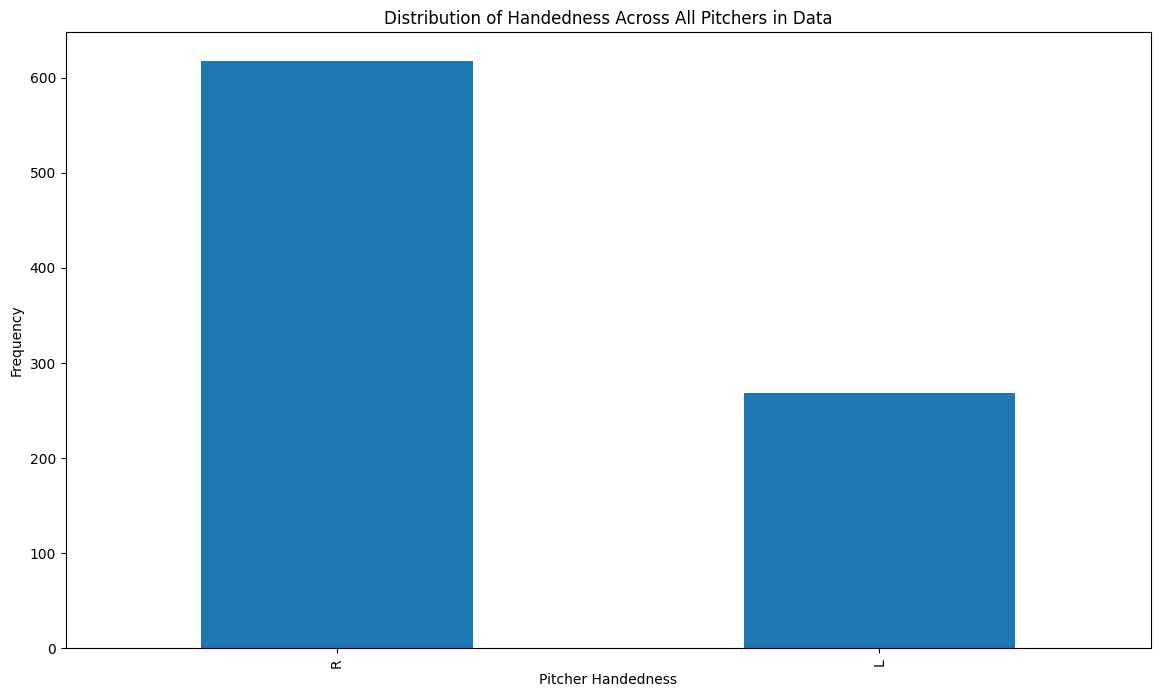

In [87]:
ax = df_pitcher_hand['hand'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Distribution of Handedness Across All Pitchers in Data")
ax.set_xlabel("Pitcher Handedness")
ax.set_ylabel("Frequency")
plt.show()

# Batter Handedness

In [161]:
with db.connect("../database/smt_2025.db") as con:
    df_batters = con.sql("""SELECT DISTINCT batter FROM game_info""").df()
    df_batter_hand = con.sql("""WITH bh AS 
                         (SELECT * FROM
                         (SELECT field_x, play_id, game_str,
                         DENSE_RANK() OVER (PARTITION BY game_str, play_id ORDER BY timestamp) AS rank
                         FROM player_pos pp
                         WHERE player_position = 10) AS subquery
                         WHERE rank = 1),
                             
                         batter_rp AS (
                         SELECT bh.game_str, bh.field_x, batter 
                         FROM bh
                         LEFT JOIN game_info gi
                         ON bh.game_str = gi.game_str AND bh.play_id = gi.play_per_game)
                             
                         SELECT AVG(field_x) avg_stance, batter FROM batter_rp
                         GROUP BY batter""").df()
    
    

df_batter_hand["batter_hand"] = np.where(df_batter_hand["avg_stance"] > 0, "L", "R")
df_batter_hand


,avg_stance,batter,batter_hand
0,2.132354,KNB-1389,L
1,-2.948370,UKI-1906,R
2,2.668513,RZQ-0318,L
3,1.677180,YJD-0185,L
4,2.760862,IAK-1196,L
...,...,...,...
1034,-0.432300,MCJ-2358,R
1035,2.822700,BEJ-1785,L
1036,-0.858800,CGA-1503,R
1037,-2.796750,REC-1542,R


In [162]:
df_pickoff_plays = pd.merge(df_pickoff_plays, df_batter_hand, on="batter", how="left")
df_pickoff_plays

,game_str,play_id,player_position,event_code,home_team,top_bottom_inning,pitcher,batter,player_name,field_x,field_y,lead_distance,count_on_first,stolen_bases,steal_score,is_home,avg_rel_point,hand,avg_stance,batter_hand
0,y1_d058_OXG_QEA,150,1,6,QEA,bottom,OXG-0109,QEA-0235,QEA-0364,55.6104,74.0472,11.896560,63.0,0.0,0.0,0,-0.597738,R,1.144432,L
1,y1_d058_OXG_QEA,212,1,6,QEA,bottom,OXG-0109,QEA-0027,NA,58.6446,68.4462,5.681810,0.0,0.0,0.0,0,-0.597738,R,0.961795,L
2,y1_d058_OXG_QEA,271,1,6,QEA,bottom,OXG-0109,QEA-0027,NA,59.0655,66.1983,3.987445,0.0,0.0,0.0,0,-0.597738,R,0.961795,L
3,y1_d059_JNJ_QEA,68,1,6,QEA,top,QEA-0013,JNJ-1459,NA,59.1960,68.9358,5.664613,0.0,0.0,0.0,1,-1.151005,R,2.639613,L
4,y1_d059_JNJ_QEA,174,1,6,QEA,bottom,JNJ-1560,QEA-0364,NA,54.9798,74.6028,12.722412,0.0,0.0,0.0,0,-1.163131,R,1.646450,L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,y2_d092_NYA_YJD,104,1,6,YJD,top,YJD-0138,NYA-2311,NYA-1911,59.4303,72.2535,8.341779,15.0,0.0,0.0,1,2.090306,L,1.163678,L
1201,y2_d099_YJD_RZQ,8,1,6,RZQ,top,RZQ-0285,YJD-0132,YJD-0019,57.4158,69.3369,7.187120,58.0,1.0,0.0,1,2.331011,L,-2.601489,R
1202,y2_d099_YJD_RZQ,108,1,6,RZQ,bottom,YJD-0386,RZQ-0414,RZQ-0328,60.1239,68.5986,4.831096,26.0,1.0,0.0,0,1.375744,L,3.210137,L
1203,y2_d092_NYA_YJD,24,1,6,YJD,top,YJD-0138,NYA-1911,NYA-1183,55.3851,69.9564,9.142387,14.0,1.0,0.0,1,2.090306,L,-1.698679,R


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 9'. Pick better value with 'binwidth'.


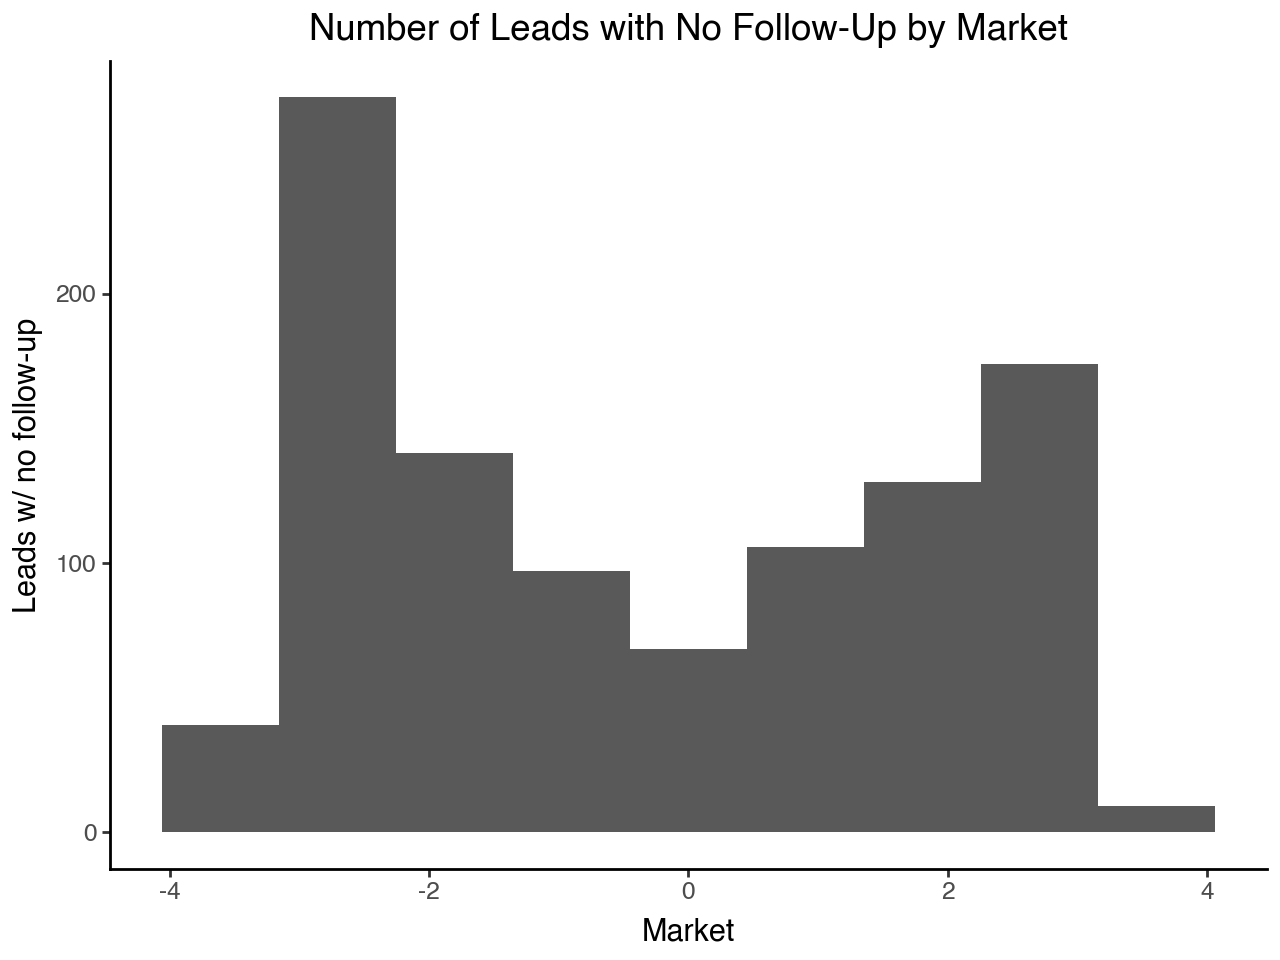

In [15]:
ggplot(df_batter_hand, aes(x='avg_stance')) \
+ geom_histogram() \
+ labs(title = "Number of Leads with No Follow-Up by Market",
       x="Market",
       y="Leads w/ no follow-up") \
+ theme_classic()

In [16]:
ax = df_batter_hand['hand'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Distribution of Handedness Across All Batters in Data")
ax.set_xlabel("Batter Handedness")
ax.set_ylabel("Frequency")

Text(0, 0.5, 'Frequency')

# Runs

In [ ]:
with db.connect("../database/smt_2025.db") as con:
    df_runs = con.sql("""
                      SELECT game_str, play_per_game, first_baserunner, second_baserunner, third_baserunner,
                      prev_first, prev_second, prev_third
                      FROM 
                      (SELECT *, LAG(first_baserunner) OVER (ORDER BY play_per_game, top_bottom_inning) AS prev_first ,
                      LAG(second_baserunner) OVER (ORDER BY play_per_game, top_bottom_inning) AS prev_second,
                      LAG(third_baserunner) OVER (ORDER BY play_per_game, top_bottom_inning) AS prev_third 
                      FROM game_info) subquery
                      WHERE (prev_first != first_baserunner AND prev_first != second_baserunner AND prev_first != third_baserunner)
                      OR (prev_second != second_baserunner AND prev_second != third_baserunner)
                      OR (prev_third != third_baserunner)
                      """).df()
    df_runs_per_play = con.sql(""" 
                      WITH run_scored AS (SELECT play_id, game_str, SUM(run) As runs FROM
                      (SELECT DISTINCT play_id, game_str, 
                      CASE 
                        WHEN (player_position = 11 AND abs(field_x) < 1 AND abs(field_y) < 1) THEN 1 
                        ELSE 0
                      END AS run          
                      FROM player_pos
                      UNION ALL
                      SELECT DISTINCT play_id, game_str, 
                      CASE 
                        WHEN (player_position = 12 AND abs(field_x) < 1 AND abs(field_y) < 1) THEN 1 
                        ELSE 0
                      END AS run
                      FROM player_pos
                      UNION ALL
                      SELECT DISTINCT play_id, game_str, 
                      CASE 
                        WHEN (player_position = 13 AND abs(field_x) < 1 AND abs(field_y) < 1) THEN 1 
                        ELSE 0
                      END AS run
                      FROM player_pos) subquery
                      GROUP BY game_str, play_id),
                               
                      run_plays AS (SELECT gi.game_str, runs, top_bottom_inning,
                      LEAD(play_per_game) OVER (PARTITION BY gi.game_str, top_bottom_inning ORDER BY play_per_game) AS play_per_game
                      FROM game_info gi
                      LEFT JOIN run_scored AS rs
                      ON rs.play_id = gi.play_per_game AND rs.game_str = gi.game_str)
                               
                      SELECT game_str, play_per_game, runs,
                          SUM(CASE WHEN top_bottom_inning = 'top' THEN runs ELSE 0 END)
                            OVER (PARTITION BY game_str ORDER BY play_per_game
                                  ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS away_score,
                          SUM(CASE WHEN top_bottom_inning = 'bottom' THEN runs ELSE 0 END)
                            OVER (PARTITION BY game_str ORDER BY play_per_game
                                  ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS home_score
                      FROM run_plays
                      ORDER BY game_str, play_per_game;""").df()
    
df_runs_per_play["run_diff"] = df_runs_per_play["home_score"] - df_runs_per_play["away_score"]
df_runs_per_play["run_diff"].value_counts()


run_diff
 0.0     27588
-1.0     10135
 1.0      9837
 2.0      6070
-2.0      5843
 3.0      3068
-3.0      2863
 4.0      1605
-4.0      1558
 5.0      1361
-5.0       966
 6.0       437
-6.0       384
 7.0       307
-7.0       123
 8.0       102
 11.0       88
-8.0        85
 10.0       66
-12.0       47
 9.0        19
-13.0        5
-9.0         4
-10.0        3
-11.0        2
Name: count, dtype: int64

In [ ]:
df_runs_per_play.to_csv("runs.csv")

In [177]:
df_runs_per_play

,game_str,play_per_game,runs,away_score,home_score,run_diff
0,y1_d001_CGA_QEA,2.0,0.0,0.0,0.0,0.0
1,y1_d001_CGA_QEA,3.0,0.0,0.0,0.0,0.0
2,y1_d001_CGA_QEA,4.0,0.0,0.0,0.0,0.0
3,y1_d001_CGA_QEA,5.0,0.0,0.0,0.0,0.0
4,y1_d001_CGA_QEA,6.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
72561,y2_d099_YJD_RZQ,290.0,0.0,0.0,5.0,5.0
72562,y2_d099_YJD_RZQ,291.0,0.0,0.0,5.0,5.0
72563,y2_d099_YJD_RZQ,292.0,0.0,0.0,5.0,5.0
72564,y2_d099_YJD_RZQ,NaN,0.0,0.0,5.0,5.0


In [ ]:
df_pickoff_plays = pd.merge(df_pickoff_plays, df_runs_per_play, left_on=['game_str', 'play_id'], right_on=['game_str', 'play_per_game'], how='left')

,game_str,play_id,player_position,event_code,home_team,top_bottom_inning,pitcher,batter,player_name,field_x,...,hand,avg_stance,batter_hand,play_per_game_x,outs,play_per_game_y,runs,away_score,home_score,run_diff
0,y1_d058_OXG_QEA,150,1,6,QEA,bottom,OXG-0109,QEA-0235,QEA-0364,55.6104,...,R,1.144432,L,150.0,0.0,150.0,0.0,1.0,1.0,0.0
1,y1_d058_OXG_QEA,212,1,6,QEA,bottom,OXG-0109,QEA-0027,NA,58.6446,...,R,0.961795,L,212.0,0.0,212.0,0.0,1.0,2.0,1.0
2,y1_d058_OXG_QEA,271,1,6,QEA,bottom,OXG-0109,QEA-0027,NA,59.0655,...,R,0.961795,L,271.0,0.0,271.0,0.0,1.0,3.0,2.0
3,y1_d059_JNJ_QEA,68,1,6,QEA,top,QEA-0013,JNJ-1459,NA,59.1960,...,R,2.639613,L,68.0,0.0,68.0,0.0,1.0,0.0,-1.0
4,y1_d059_JNJ_QEA,174,1,6,QEA,bottom,JNJ-1560,QEA-0364,NA,54.9798,...,R,1.646450,L,174.0,0.0,174.0,0.0,2.0,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1214,y2_d092_NYA_YJD,104,1,6,YJD,top,YJD-0138,NYA-2311,NYA-1911,59.4303,...,L,1.163678,L,104.0,0.0,104.0,0.0,0.0,0.0,0.0
1215,y2_d099_YJD_RZQ,8,1,6,RZQ,top,RZQ-0285,YJD-0132,YJD-0019,57.4158,...,L,-2.601489,R,8.0,1.0,8.0,0.0,0.0,0.0,0.0
1216,y2_d099_YJD_RZQ,108,1,6,RZQ,bottom,YJD-0386,RZQ-0414,RZQ-0328,60.1239,...,L,3.210137,L,108.0,0.0,108.0,0.0,0.0,2.0,2.0
1217,y2_d092_NYA_YJD,24,1,6,YJD,top,YJD-0138,NYA-1911,NYA-1183,55.3851,...,L,-1.698679,R,24.0,0.0,24.0,0.0,0.0,0.0,0.0


# Outs

In [201]:
with db.connect("../database/smt_2025.db") as con:
    df_outs = con.sql("""WITH runner_info AS
                                 (SELECT *, 
                                 LAG(first_baserunner) OVER (PARTITION BY game_str, top_bottom_inning ORDER BY play_per_game) AS next_first,
                                 LAG(second_baserunner) OVER (PARTITION BY game_str, top_bottom_inning ORDER BY play_per_game) AS next_second,
                                 LAG(third_baserunner) OVER (PARTITION BY game_str, top_bottom_inning ORDER BY play_per_game) AS next_third
                                 FROM game_info)

                                 SELECT DISTINCT game_str, play_per_game, SUM(out) as outs
                                 FROM
                                 (SELECT game_str, top_bottom_inning, play_per_game, 
                                 CASE 
                                    WHEN first_baserunner NOT IN (next_first, next_second, next_third) THEN 1 
                                    ELSE 0
                                    END AS out
                                 FROM runner_info
                                 UNION ALL
                                 SELECT game_str, top_bottom_inning, play_per_game, 
                                 CASE 
                                    WHEN second_baserunner NOT IN (next_first, next_second, next_third) THEN 1 
                                    ELSE 0
                                    END AS out
                                 FROM runner_info
                                 UNION ALL
                                 SELECT game_str, top_bottom_inning, play_per_game, 
                                 CASE 
                                    WHEN third_baserunner NOT IN (next_first, next_second, next_third) THEN 1 
                                    ELSE 0
                                    END AS out
                                 FROM runner_info) subquery
                                 GROUP BY game_str, play_per_game
                                 """).df()
df_outs["outs"] = np.where(df_outs["outs"] > 3, 0, df_outs["outs"])
df_outs_recorded = df_outs[df_outs["outs"] > 0]
df_outs_recorded.to_csv("out_plays.csv")

In [188]:
df_pickoff_plays = pd.merge(df_pickoff_plays, df_outs, left_on=['game_str', 'play_id'], right_on=['game_str', 'play_per_game'], how='left')
df_pickoff_plays

,game_str,play_id,player_position,event_code,home_team,top_bottom_inning,pitcher,batter,player_name,field_x,...,batter_hand,play_per_game_x,outs_x,play_per_game_y,runs,away_score,home_score,run_diff,play_per_game,outs_y
0,y1_d058_OXG_QEA,150,1,6,QEA,bottom,OXG-0109,QEA-0235,QEA-0364,55.6104,...,L,150.0,0.0,150.0,0.0,1.0,1.0,0.0,150.0,0.0
1,y1_d058_OXG_QEA,212,1,6,QEA,bottom,OXG-0109,QEA-0027,NA,58.6446,...,L,212.0,0.0,212.0,0.0,1.0,2.0,1.0,212.0,0.0
2,y1_d058_OXG_QEA,271,1,6,QEA,bottom,OXG-0109,QEA-0027,NA,59.0655,...,L,271.0,0.0,271.0,0.0,1.0,3.0,2.0,271.0,0.0
3,y1_d059_JNJ_QEA,68,1,6,QEA,top,QEA-0013,JNJ-1459,NA,59.1960,...,L,68.0,0.0,68.0,0.0,1.0,0.0,-1.0,68.0,0.0
4,y1_d059_JNJ_QEA,174,1,6,QEA,bottom,JNJ-1560,QEA-0364,NA,54.9798,...,L,174.0,0.0,174.0,0.0,2.0,1.0,-1.0,174.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1214,y2_d092_NYA_YJD,104,1,6,YJD,top,YJD-0138,NYA-2311,NYA-1911,59.4303,...,L,104.0,0.0,104.0,0.0,0.0,0.0,0.0,104.0,0.0
1215,y2_d099_YJD_RZQ,8,1,6,RZQ,top,RZQ-0285,YJD-0132,YJD-0019,57.4158,...,R,8.0,1.0,8.0,0.0,0.0,0.0,0.0,8.0,1.0
1216,y2_d099_YJD_RZQ,108,1,6,RZQ,bottom,YJD-0386,RZQ-0414,RZQ-0328,60.1239,...,L,108.0,0.0,108.0,0.0,0.0,2.0,2.0,108.0,0.0
1217,y2_d092_NYA_YJD,24,1,6,YJD,top,YJD-0138,NYA-1911,NYA-1183,55.3851,...,R,24.0,0.0,24.0,0.0,0.0,0.0,0.0,24.0,0.0


In [166]:
df_pickoff_plays["outs"].value_counts()

outs
0.0    979
1.0    217
Name: count, dtype: int64

# Play Animation

In [197]:
import pandas as pd
from sportypy.surfaces import MiLBField
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from IPython.display import HTML

def plot_animation(player_position_df: pd.DataFrame, 
                   ball_position_df: pd.DataFrame, 
                   play_id: int = 1, 
                   save_gif: bool = False) -> HTML:
    
    """
    A function that plots field animations for a particular instance of a game.
    Example usage:
    
    ```
    player_pos = pd.read_parquet('./Combined/player_pos/1884_110_Vis2AR_Home2A.parquet')
    ball_pos = pd.read_parquet('./Combined/ball_pos/1884_110_Vis2AR_Home2A.parquet')
    
    plot_animation(player_pos, ball_pos, play_id = 30, save_gif = True)
    ```
    
    Params:
        player_position_df: A Data Frame for the player position coordinates on a field.
        ball_position_df: A Data Frame for the ball position coordiantes on a field.
        play_id: A integer field that denotes the play id you want to visualize. Defaults to 1.
        save_gif: A boolean that when set to true saves the animation to a gif. 
                  Defaults to not saving animation (False).
    
    Returns:
        HTML display of the animation. You can slow or speed up the fps with the + and - buttons.
        You can also press the > arrow to start the animation.
    """
    
    if not isinstance(play_id, int):
        raise ValueError("Play ID must be an Integer. This function only handles one Play ID.")
    
    if len(player_position_df['game_str'].unique()) > 1 or len(ball_position_df['game_str'].unique()) > 1:
        raise ValueError("Player Position or Ball Position Data Frame has multiple games. Please filter for one game at a time.")
    
    player_pos = player_position_df.query(f'play_id == {play_id}')
    ball_pos = ball_position_df.query(f'play_id == {play_id}')
    
    merged_df = pd.merge(player_pos, ball_pos, on = ['timestamp', 'play_id', 'game_str'], how = 'inner')
    merged_df = merged_df[merged_df['player_position'] < 14] # Elminate umpires and coaches on field
    
    field = MiLBField()
    field.draw(display_range='infield')

    fig = plt.gcf()
    ax = plt.gca()

    p = field.scatter([], [], c='white')
    b = field.scatter([], [], c='red')

    game_id = merged_df['game_str'].unique()[0]
    game_text = ax.text(0, 400, f'Game ID: {game_id}', c='white', ha='center')
    play_text = ax.text(120, 0, f'Play: {play_id}', c='white', ha='center')


    def update(frame):
        frame_data = merged_df[merged_df['timestamp'] <= frame]

        players = frame_data.sort_values('timestamp').drop_duplicates(subset=['player_position'], keep='last')
        balls = frame_data[['ball_position_x', 'ball_position_y', 'ball_position_z']].dropna().iloc[-1:]

        players_colors = ['yellow' if 10 <= pos <= 13 else 'white' for pos in players['player_position']]

        p.set_offsets(np.c_[players['field_x'], players['field_y']])
        p.set_color(players_colors)

        ball_size = (balls['ball_position_z'].values * 8)
        b.set_offsets(np.c_[balls['ball_position_x'], balls['ball_position_y']])
        
        if ball_size < 1:
             ball_size = np.array([10])
                

        return p, b

    ani = FuncAnimation(fig, update, frames=np.linspace(merged_df['timestamp'].min(), 
                                                        merged_df['timestamp'].max(), num=50), blit=True)

    if save_gif:
        ani.save('animation.gif', writer='imagemagick', fps=10)
    
    return HTML(ani.to_jshtml())

In [198]:
with db.connect("../database/smt_2025.db") as con:

    player_position_df = con.sql("""SELECT * FROM player_pos  
                                    WHERE game_str = 'y2_d072_DYE_YJD'; """).df()
    ball_position_df = con.sql("""SELECT * FROM ball_pos  
                                    WHERE game_str = 'y2_d072_DYE_YJD'; """).df()

# Animate play
# Arguments are player_pos, ball_pos, play_id, and whether we want to save the animation afterwards
plot_animation(player_position_df, ball_position_df, 259, False)

In [29]:
from backend.animation.Animation import plot_animation
def random_play(df):
    random_row = df.sample(n=1).reset_index(drop=True)
    try:
        with db.connect("../database/smt_2025.db") as con:
                game_string = random_row["game_str"].iloc[0]
                print(game_string)
                play_id = random_row["play_per_game"].iloc[0]
                player_position_df = con.sql(f"""SELECT * FROM player_pos  
                                                WHERE game_str = '{game_string}';""").df()
                ball_position_df = con.sql(f"""SELECT * FROM ball_pos  
                                                WHERE game_str = '{game_string}';""").df()
                plot_animation(player_position_df, ball_position_df, int(play_id), True)
                return
    except: 
        random_play(df)

y2_d033_KNB_YJD
y1_d034_AVV_YJD


MovieWriter imagemagick unavailable; using Pillow instead.


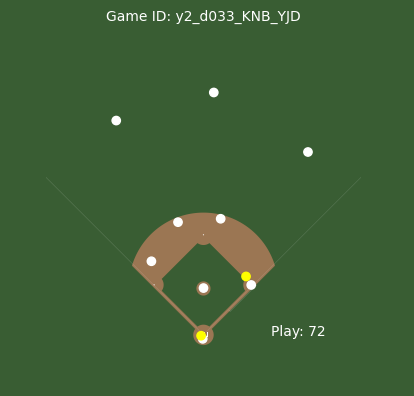

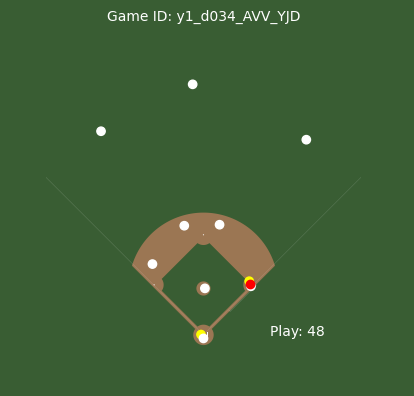

In [30]:
df_pick = pd.read_csv("../database/pickoff_plays.csv")
random_play(df_pick)